## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


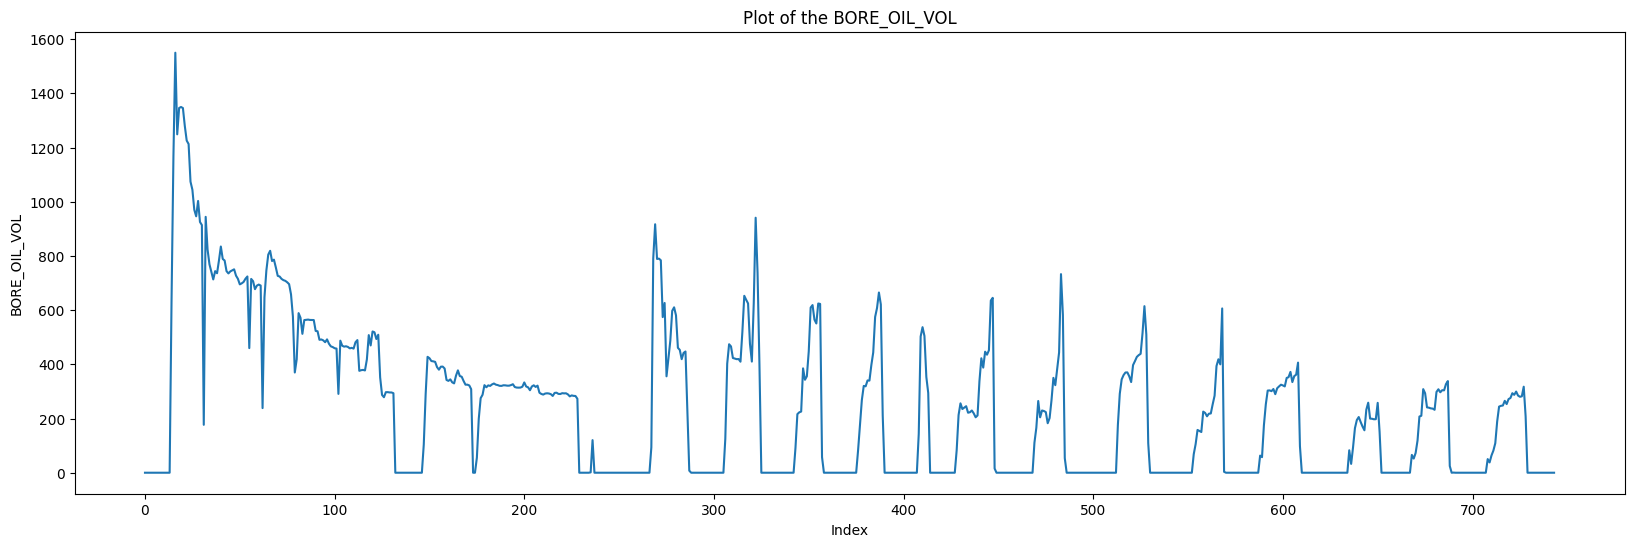

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


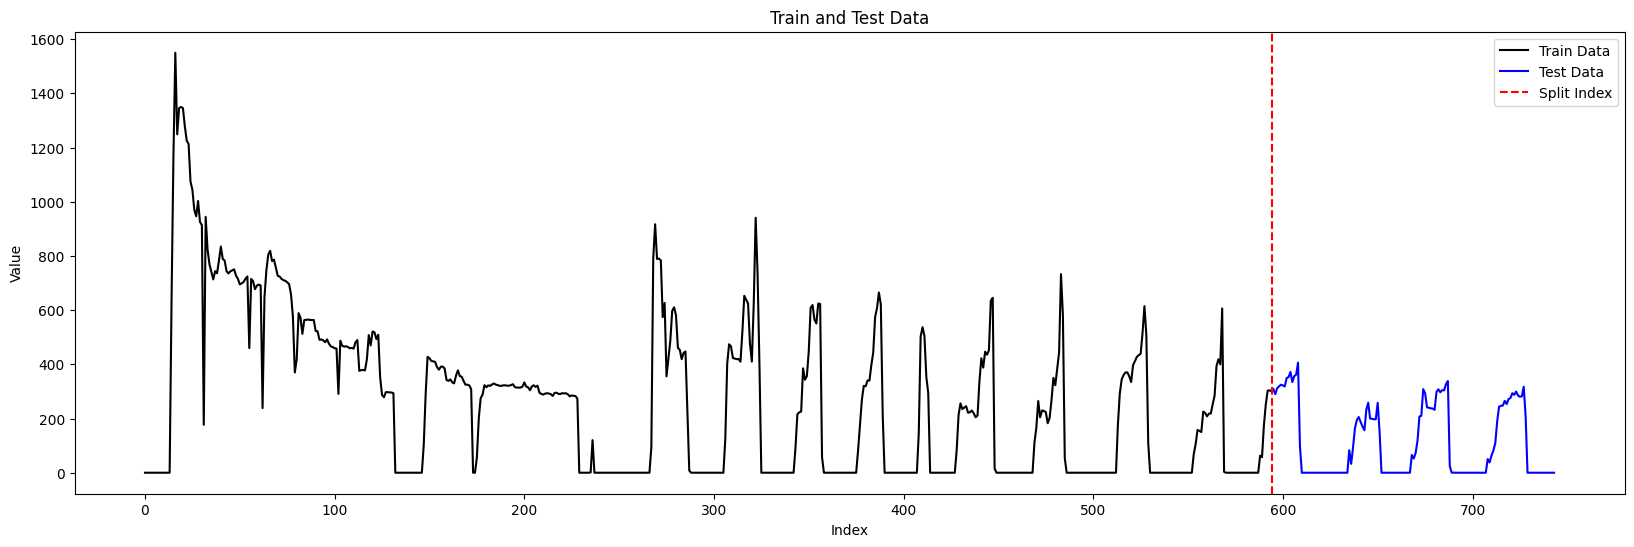

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('window_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    Dropout_rate = trial.suggest_float('Dropout_rate', 0.1, 0.5)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
        model_LSTM.add(Dropout(Dropout_rate))
    
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-10-25 09:00:57,164] A new study created in memory with name: no-name-c5d44825-0dba-472f-8d30-e5d166ebebc2


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://8c1be98f-2b6a-478a-8816-4f8a6a135062/assets


INFO:tensorflow:Assets written to: ram://8c1be98f-2b6a-478a-8816-4f8a6a135062/assets
[I 2023-10-25 09:09:41,411] Trial 0 finished with value: 0.016873864457011223 and parameters: {'window_size': 34, 'n_lstm_layers': 12, 'lstm_units': 146, 'learning_rate': 0.004393180926354533, 'Dropout_rate': 0.18793444307393223}. Best is trial 0 with value: 0.016873864457011223.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://fe6a6014-07b5-4aa6-bafa-e5a710069fb6/assets


INFO:tensorflow:Assets written to: ram://fe6a6014-07b5-4aa6-bafa-e5a710069fb6/assets
[I 2023-10-25 09:23:15,179] Trial 1 finished with value: 0.025820014998316765 and parameters: {'window_size': 13, 'n_lstm_layers': 14, 'lstm_units': 57, 'learning_rate': 0.008152054036511319, 'Dropout_rate': 0.3569955676903557}. Best is trial 0 with value: 0.016873864457011223.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://5086ee98-8193-4c84-b046-d36ae2e7163f/assets


INFO:tensorflow:Assets written to: ram://5086ee98-8193-4c84-b046-d36ae2e7163f/assets
[I 2023-10-25 09:34:20,117] Trial 2 finished with value: 0.0020402586087584496 and parameters: {'window_size': 10, 'n_lstm_layers': 8, 'lstm_units': 65, 'learning_rate': 0.0007733715870985217, 'Dropout_rate': 0.3187377971381219}. Best is trial 2 with value: 0.0020402586087584496.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://e16548bb-dd7d-4612-92f6-f343e13a687f/assets


INFO:tensorflow:Assets written to: ram://e16548bb-dd7d-4612-92f6-f343e13a687f/assets
[I 2023-10-25 09:38:49,788] Trial 3 finished with value: 0.07715664803981781 and parameters: {'window_size': 45, 'n_lstm_layers': 6, 'lstm_units': 158, 'learning_rate': 0.002524072258948971, 'Dropout_rate': 0.43857815030847913}. Best is trial 2 with value: 0.0020402586087584496.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://23407db3-28c0-4407-9974-4f067f378218/assets


INFO:tensorflow:Assets written to: ram://23407db3-28c0-4407-9974-4f067f378218/assets
[I 2023-10-25 09:53:56,473] Trial 4 finished with value: 0.02892044186592102 and parameters: {'window_size': 6, 'n_lstm_layers': 8, 'lstm_units': 149, 'learning_rate': 0.008362037957306664, 'Dropout_rate': 0.3766020565232121}. Best is trial 2 with value: 0.0020402586087584496.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 09:54:09,368] Trial 5 pruned. 
[I 2023-10-25 09:54:45,649] Trial 6 pruned. 
[I 2023-10-25 09:55:11,92

INFO:tensorflow:Assets written to: ram://fb280e5f-14e0-483f-ae85-f5c1f19c9f5a/assets


INFO:tensorflow:Assets written to: ram://fb280e5f-14e0-483f-ae85-f5c1f19c9f5a/assets
[I 2023-10-25 10:03:50,782] Trial 8 finished with value: 0.014335541054606438 and parameters: {'window_size': 53, 'n_lstm_layers': 13, 'lstm_units': 185, 'learning_rate': 0.00252604048174775, 'Dropout_rate': 0.20758562280215542}. Best is trial 2 with value: 0.0020402586087584496.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://c0b9054b-fd9b-4124-8acb-5e2b4e4e5043/assets


INFO:tensorflow:Assets written to: ram://c0b9054b-fd9b-4124-8acb-5e2b4e4e5043/assets
[I 2023-10-25 10:08:32,363] Trial 9 finished with value: 0.0011980300769209862 and parameters: {'window_size': 54, 'n_lstm_layers': 6, 'lstm_units': 190, 'learning_rate': 0.0008673659641585926, 'Dropout_rate': 0.2328592893231597}. Best is trial 9 with value: 0.0011980300769209862.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://120fbe6b-979f-4ae1-a541-69cfff9e8850/assets


INFO:tensorflow:Assets written to: ram://120fbe6b-979f-4ae1-a541-69cfff9e8850/assets
[I 2023-10-25 10:10:45,009] Trial 10 finished with value: 0.0008911460754461586 and parameters: {'window_size': 24, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.00015406033408942206, 'Dropout_rate': 0.11098830989261164}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://292b7936-5681-4a18-9455-070f3cd2063e/assets


INFO:tensorflow:Assets written to: ram://292b7936-5681-4a18-9455-070f3cd2063e/assets
[I 2023-10-25 10:13:01,536] Trial 11 finished with value: 0.0014868031721562147 and parameters: {'window_size': 21, 'n_lstm_layers': 1, 'lstm_units': 255, 'learning_rate': 0.0002743464814140853, 'Dropout_rate': 0.11276898597741777}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://10a531d6-04ca-4bad-be1b-01ccacbcda4e/assets


INFO:tensorflow:Assets written to: ram://10a531d6-04ca-4bad-be1b-01ccacbcda4e/assets
[I 2023-10-25 10:15:09,469] Trial 12 finished with value: 0.0010525683173909783 and parameters: {'window_size': 22, 'n_lstm_layers': 1, 'lstm_units': 216, 'learning_rate': 0.00012504290219216444, 'Dropout_rate': 0.4930147890510927}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://db43f445-f2a1-4f64-bf4a-4b6bd14b04c6/assets


INFO:tensorflow:Assets written to: ram://db43f445-f2a1-4f64-bf4a-4b6bd14b04c6/assets
[I 2023-10-25 10:17:17,934] Trial 13 finished with value: 0.002174010965973139 and parameters: {'window_size': 22, 'n_lstm_layers': 1, 'lstm_units': 223, 'learning_rate': 0.002087993500670211, 'Dropout_rate': 0.4958164921706719}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 10:17:25,756] Trial 14 pruned. 


INFO:tensorflow:Assets written to: ram://92dafcfe-6adf-485d-8600-cebdeaf7c9ec/assets


INFO:tensorflow:Assets written to: ram://92dafcfe-6adf-485d-8600-cebdeaf7c9ec/assets
[I 2023-10-25 10:20:52,122] Trial 15 finished with value: 0.005302709527313709 and parameters: {'window_size': 28, 'n_lstm_layers': 3, 'lstm_units': 256, 'learning_rate': 0.004171963446396031, 'Dropout_rate': 0.4884244955207932}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 10:21:02,282] Trial 16 pruned. 
[I 2023-10-25 10:21:37,086] Trial 17 pruned. 
[I 2023-10-25 10:22

INFO:tensorflow:Assets written to: ram://8772ef8b-ecee-4b91-bfec-1245a01d122b/assets


INFO:tensorflow:Assets written to: ram://8772ef8b-ecee-4b91-bfec-1245a01d122b/assets
[I 2023-10-25 10:27:39,104] Trial 19 finished with value: 0.0012993672862648964 and parameters: {'window_size': 5, 'n_lstm_layers': 1, 'lstm_units': 247, 'learning_rate': 0.00013047692778953246, 'Dropout_rate': 0.2582559260981041}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 10:27:49,107] Trial 20 pruned. 
[I 2023-10-25 10:27:59,425] Trial 21 pruned. 
[I 2023-10-25 10:

[I 2023-10-25 10:28:39,247] Trial 24 pruned. 


[I 2023-10-25 10:28:49,250] Trial 25 pruned. 
[I 2023-10-25 10:29:04,207] Trial 26 pruned. 
[I 2023-10-25 10:29:13,959] Trial 27 pruned. 
[I 2023-10-25 10:29:21,994] Trial 28 pruned. 
[I 2023-10-25 10:29:44,236] Trial 29 pruned. 
[I 2023-10-25 10:29:56,053] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://48862db1-5810-442c-a2e3-7bd6f1d00420/assets


INFO:tensorflow:Assets written to: ram://48862db1-5810-442c-a2e3-7bd6f1d00420/assets
[I 2023-10-25 10:41:24,826] Trial 31 finished with value: 0.0012252168962731957 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0004640210290821698, 'Dropout_rate': 0.10096200869071217}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 10:41:31,230] Trial 32 pruned. 


INFO:tensorflow:Assets written to: ram://f3906699-718c-465c-9f3a-90bc35c7419f/assets


INFO:tensorflow:Assets written to: ram://f3906699-718c-465c-9f3a-90bc35c7419f/assets
[I 2023-10-25 10:45:13,557] Trial 33 finished with value: 0.0016997716156765819 and parameters: {'window_size': 8, 'n_lstm_layers': 1, 'lstm_units': 131, 'learning_rate': 0.0006839696293616375, 'Dropout_rate': 0.13494457898021073}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 10:45:49,336] Trial 34 pruned. 
[I 2023-10-25 10:45:57,650] Trial 35 pruned. 
[I 2023-10-25 10:

INFO:tensorflow:Assets written to: ram://a5e4773a-4c6f-424b-a2ba-c044e59da0da/assets


INFO:tensorflow:Assets written to: ram://a5e4773a-4c6f-424b-a2ba-c044e59da0da/assets
[I 2023-10-25 10:58:32,226] Trial 40 finished with value: 0.001225829473696649 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 146, 'learning_rate': 0.00046521875731021545, 'Dropout_rate': 0.12318303384636636}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://5154330f-4c80-4d31-9477-f41a9a85c2f1/assets


INFO:tensorflow:Assets written to: ram://5154330f-4c80-4d31-9477-f41a9a85c2f1/assets
[I 2023-10-25 11:01:56,135] Trial 41 finished with value: 0.0014379143249243498 and parameters: {'window_size': 9, 'n_lstm_layers': 1, 'lstm_units': 150, 'learning_rate': 0.0004945121606781378, 'Dropout_rate': 0.1162382244289199}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 11:02:03,450] Trial 42 pruned. 
[I 2023-10-25 11:02:15,844] Trial 43 pruned. 


INFO:tensorflow:Assets written to: ram://6d452a90-dc54-43a6-beeb-a092e40ccb69/assets


INFO:tensorflow:Assets written to: ram://6d452a90-dc54-43a6-beeb-a092e40ccb69/assets
[I 2023-10-25 11:04:10,500] Trial 44 finished with value: 0.002426750957965851 and parameters: {'window_size': 21, 'n_lstm_layers': 1, 'lstm_units': 94, 'learning_rate': 0.0017427464859428939, 'Dropout_rate': 0.1250316062216174}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 11:04:19,316] Trial 45 pruned. 
[I 2023-10-25 11:04:43,978] Trial 46 pruned. 
[I 2023-10-25 11:04

INFO:tensorflow:Assets written to: ram://214f4eda-175b-49c8-a788-fca1040efa77/assets


INFO:tensorflow:Assets written to: ram://214f4eda-175b-49c8-a788-fca1040efa77/assets
[I 2023-10-25 11:15:33,399] Trial 52 finished with value: 0.0012081508757546544 and parameters: {'window_size': 4, 'n_lstm_layers': 3, 'lstm_units': 224, 'learning_rate': 0.0005539291249813988, 'Dropout_rate': 0.34283258987203014}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://1c9e2b1a-74b0-479a-bdb1-71c66bccd1e1/assets


INFO:tensorflow:Assets written to: ram://1c9e2b1a-74b0-479a-bdb1-71c66bccd1e1/assets
[I 2023-10-25 11:34:28,817] Trial 53 finished with value: 0.0021483968012034893 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 237, 'learning_rate': 0.0005912100934808517, 'Dropout_rate': 0.35020064358744174}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://1ab13614-6162-4299-b001-7f8162bd4606/assets


INFO:tensorflow:Assets written to: ram://1ab13614-6162-4299-b001-7f8162bd4606/assets
[I 2023-10-25 11:37:09,187] Trial 54 finished with value: 0.005867912899702787 and parameters: {'window_size': 27, 'n_lstm_layers': 2, 'lstm_units': 225, 'learning_rate': 0.0010778937066906287, 'Dropout_rate': 0.47660771838650356}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 11:37:17,722] Trial 55 pruned. 
[I 2023-10-25 11:37:27,756] Trial 56 pruned. 


INFO:tensorflow:Assets written to: ram://9e44d1a0-e82c-424b-b9e3-46865b4cfef5/assets


INFO:tensorflow:Assets written to: ram://9e44d1a0-e82c-424b-b9e3-46865b4cfef5/assets
[I 2023-10-25 11:43:51,464] Trial 57 finished with value: 0.0012180194025859237 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0009030856296355636, 'Dropout_rate': 0.14972325829703428}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 11:44:02,792] Trial 58 pruned. 
[I 2023-10-25 11:44:08,920] Trial 59 pruned. 
[I 2023-10-25 11:

INFO:tensorflow:Assets written to: ram://ce25bf26-1141-4acf-b3e9-e17d7ecb1a7b/assets


INFO:tensorflow:Assets written to: ram://ce25bf26-1141-4acf-b3e9-e17d7ecb1a7b/assets
[I 2023-10-25 11:48:56,530] Trial 61 finished with value: 0.001425107941031456 and parameters: {'window_size': 6, 'n_lstm_layers': 1, 'lstm_units': 218, 'learning_rate': 0.0005098087611354166, 'Dropout_rate': 0.11587214231373079}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://322cbd2d-7e58-4157-b94f-dd69ab8aee12/assets


INFO:tensorflow:Assets written to: ram://322cbd2d-7e58-4157-b94f-dd69ab8aee12/assets
[I 2023-10-25 11:55:11,449] Trial 62 finished with value: 0.0012498012511059642 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 236, 'learning_rate': 0.0015698537596845882, 'Dropout_rate': 0.14252513456154126}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://cd764f9a-d6d9-4659-bc7d-a5806c9d17d4/assets


INFO:tensorflow:Assets written to: ram://cd764f9a-d6d9-4659-bc7d-a5806c9d17d4/assets
[I 2023-10-25 12:04:11,294] Trial 63 finished with value: 0.0012151807313784957 and parameters: {'window_size': 3, 'n_lstm_layers': 2, 'lstm_units': 191, 'learning_rate': 0.00032352957941437057, 'Dropout_rate': 0.11393426239455245}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 12:04:21,444] Trial 64 pruned. 
[I 2023-10-25 12:04:27,680] Trial 65 pruned. 


INFO:tensorflow:Assets written to: ram://753f0045-48a6-45e0-9269-18435cf464c4/assets


INFO:tensorflow:Assets written to: ram://753f0045-48a6-45e0-9269-18435cf464c4/assets
[I 2023-10-25 12:14:46,381] Trial 66 finished with value: 0.001441767904907465 and parameters: {'window_size': 4, 'n_lstm_layers': 3, 'lstm_units': 204, 'learning_rate': 0.0011872638236766942, 'Dropout_rate': 0.10063359743897765}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 12:15:01,945] Trial 67 pruned. 
[I 2023-10-25 12:15:13,306] Trial 68 pruned. 
[I 2023-10-25 12:1

INFO:tensorflow:Assets written to: ram://d700f2a7-099a-4e49-96e6-ffdc68ee46f4/assets


INFO:tensorflow:Assets written to: ram://d700f2a7-099a-4e49-96e6-ffdc68ee46f4/assets
[I 2023-10-25 12:22:41,198] Trial 71 finished with value: 0.0012944655027240515 and parameters: {'window_size': 3, 'n_lstm_layers': 1, 'lstm_units': 230, 'learning_rate': 0.00044751489647922775, 'Dropout_rate': 0.12217574089126503}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 12:22:48,356] Trial 72 pruned. 
[I 2023-10-25 12:22:55,235] Trial 73 pruned. 
[I 2023-10-25 12

INFO:tensorflow:Assets written to: ram://72dd384b-8231-46d0-8bc2-ec77da63819a/assets


INFO:tensorflow:Assets written to: ram://72dd384b-8231-46d0-8bc2-ec77da63819a/assets
[I 2023-10-25 12:34:47,628] Trial 75 finished with value: 0.0013058852637186646 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 142, 'learning_rate': 0.0007412092991420716, 'Dropout_rate': 0.12483579179120463}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 12:34:53,943] Trial 76 pruned. 
[I 2023-10-25 12:35:01,602] Trial 77 pruned. 
[I 2023-10-25 12:

INFO:tensorflow:Assets written to: ram://515b7747-51b7-4140-b8c2-6a5ba4128528/assets


INFO:tensorflow:Assets written to: ram://515b7747-51b7-4140-b8c2-6a5ba4128528/assets
[I 2023-10-25 12:42:46,699] Trial 82 finished with value: 0.0018907967023551464 and parameters: {'window_size': 5, 'n_lstm_layers': 2, 'lstm_units': 242, 'learning_rate': 0.0014638745865148649, 'Dropout_rate': 0.11190903787158826}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://9ea3529c-5c07-43f7-ac7e-e8a6a3f5e381/assets


INFO:tensorflow:Assets written to: ram://9ea3529c-5c07-43f7-ac7e-e8a6a3f5e381/assets
[I 2023-10-25 12:46:25,502] Trial 83 finished with value: 0.001793330884538591 and parameters: {'window_size': 9, 'n_lstm_layers': 1, 'lstm_units': 251, 'learning_rate': 0.001088791869044157, 'Dropout_rate': 0.141580563041728}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 12:46:31,612] Trial 84 pruned. 
[I 2023-10-25 12:46:36,644] Trial 85 pruned. 
[I 2023-10-25 12:46:4

INFO:tensorflow:Assets written to: ram://95a81409-8751-4cde-b5fb-6fbf3564bf0f/assets


INFO:tensorflow:Assets written to: ram://95a81409-8751-4cde-b5fb-6fbf3564bf0f/assets
[I 2023-10-25 12:54:25,854] Trial 91 finished with value: 0.001205368316732347 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 231, 'learning_rate': 0.00041912076536047615, 'Dropout_rate': 0.13715510716960536}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 12:54:32,651] Trial 92 pruned. 


INFO:tensorflow:Assets written to: ram://33bba65e-afea-48d3-93d1-d81b85fe52c4/assets


INFO:tensorflow:Assets written to: ram://33bba65e-afea-48d3-93d1-d81b85fe52c4/assets
[I 2023-10-25 13:00:48,869] Trial 93 finished with value: 0.0011811964213848114 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 244, 'learning_rate': 0.00029077361577320134, 'Dropout_rate': 0.13605520440469765}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 13:00:53,371] Trial 94 pruned. 
[I 2023-10-25 13:00:59,670] Trial 95 pruned. 


INFO:tensorflow:Assets written to: ram://8f4a468d-cd55-4903-9c95-de4ccbc58b13/assets


INFO:tensorflow:Assets written to: ram://8f4a468d-cd55-4903-9c95-de4ccbc58b13/assets
[I 2023-10-25 13:19:58,879] Trial 96 finished with value: 0.002160323318094015 and parameters: {'window_size': 2, 'n_lstm_layers': 3, 'lstm_units': 250, 'learning_rate': 0.0009459210202502213, 'Dropout_rate': 0.10713184883261287}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://4163ddc5-a568-4378-bfe3-c3d8f229d00f/assets


INFO:tensorflow:Assets written to: ram://4163ddc5-a568-4378-bfe3-c3d8f229d00f/assets
[I 2023-10-25 13:26:22,478] Trial 97 finished with value: 0.0012189754052087665 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0006094540038390169, 'Dropout_rate': 0.13482395799772157}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://524fb649-a364-4926-ab0b-6da62fcc5450/assets


INFO:tensorflow:Assets written to: ram://524fb649-a364-4926-ab0b-6da62fcc5450/assets
[I 2023-10-25 13:32:46,948] Trial 98 finished with value: 0.0011914600618183613 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.0006226418347172125, 'Dropout_rate': 0.16352668048407473}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 13:33:06,385] Trial 99 pruned. 
[I 2023-10-25 13:33:19,795] Trial 100 pruned. 
[I 2023-10-25 13

INFO:tensorflow:Assets written to: ram://8c3c8bb4-53c6-4145-ad82-42817511675d/assets


INFO:tensorflow:Assets written to: ram://8c3c8bb4-53c6-4145-ad82-42817511675d/assets
[I 2023-10-25 13:41:57,706] Trial 102 finished with value: 0.0012085740454494953 and parameters: {'window_size': 4, 'n_lstm_layers': 2, 'lstm_units': 250, 'learning_rate': 0.0005686039907538567, 'Dropout_rate': 0.15186190601655547}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://69c0fa03-e646-4e84-90df-a824d61b9bd9/assets


INFO:tensorflow:Assets written to: ram://69c0fa03-e646-4e84-90df-a824d61b9bd9/assets
[I 2023-10-25 13:49:26,773] Trial 103 finished with value: 0.0011073470814153552 and parameters: {'window_size': 4, 'n_lstm_layers': 2, 'lstm_units': 253, 'learning_rate': 0.0007007348502557785, 'Dropout_rate': 0.14861859695290697}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 13:49:33,056] Trial 104 pruned. 
[I 2023-10-25 13:49:39,620] Trial 105 pruned. 
[I 2023-10-25 

INFO:tensorflow:Assets written to: ram://c4f76cda-1f4d-4279-86fd-b7a82776de30/assets


INFO:tensorflow:Assets written to: ram://c4f76cda-1f4d-4279-86fd-b7a82776de30/assets
[I 2023-10-25 13:57:22,535] Trial 111 finished with value: 0.0012244790559634566 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 244, 'learning_rate': 0.0005902882438791746, 'Dropout_rate': 0.13885342085212785}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://56cfab81-a2a0-462b-97c8-24df08e3000a/assets


INFO:tensorflow:Assets written to: ram://56cfab81-a2a0-462b-97c8-24df08e3000a/assets
[I 2023-10-25 14:03:54,437] Trial 112 finished with value: 0.0011372509179636836 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 230, 'learning_rate': 0.00029233498101256274, 'Dropout_rate': 0.128218177017062}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 14:04:06,761] Trial 113 pruned. 
[I 2023-10-25 14:04:17,077] Trial 114 pruned. 
[I 2023-10-25 1

INFO:tensorflow:Assets written to: ram://a2c9b1e8-291e-420f-992e-ee0ba57c1536/assets


INFO:tensorflow:Assets written to: ram://a2c9b1e8-291e-420f-992e-ee0ba57c1536/assets
[I 2023-10-25 14:12:08,299] Trial 120 finished with value: 0.0012564166681841016 and parameters: {'window_size': 3, 'n_lstm_layers': 1, 'lstm_units': 238, 'learning_rate': 0.0007458894871826113, 'Dropout_rate': 0.28364760614307444}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://6384af19-238f-446e-9f15-608a1bf09153/assets


INFO:tensorflow:Assets written to: ram://6384af19-238f-446e-9f15-608a1bf09153/assets
[I 2023-10-25 14:18:32,887] Trial 121 finished with value: 0.001223410596139729 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.0005715332884170805, 'Dropout_rate': 0.13157026693239007}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 14:18:42,197] Trial 122 pruned. 
[I 2023-10-25 14:18:52,779] Trial 123 pruned. 


INFO:tensorflow:Assets written to: ram://dcf72be3-6212-4c51-8229-980bde56f1d1/assets


INFO:tensorflow:Assets written to: ram://dcf72be3-6212-4c51-8229-980bde56f1d1/assets
[I 2023-10-25 14:30:25,047] Trial 124 finished with value: 0.0015530092641711235 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 233, 'learning_rate': 0.0010901045510650653, 'Dropout_rate': 0.15645444421199634}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 14:30:31,838] Trial 125 pruned. 
[I 2023-10-25 14:30:57,630] Trial 126 pruned. 
[I 2023-10-25 

INFO:tensorflow:Assets written to: ram://ebf63a54-fc04-4172-9526-e50d3dfd5731/assets


INFO:tensorflow:Assets written to: ram://ebf63a54-fc04-4172-9526-e50d3dfd5731/assets
[I 2023-10-25 14:38:07,462] Trial 130 finished with value: 0.0012561309849843383 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 233, 'learning_rate': 0.001383853796736393, 'Dropout_rate': 0.10693183666051112}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://106bd9f7-02a2-45ad-a48d-f6880020dda8/assets


INFO:tensorflow:Assets written to: ram://106bd9f7-02a2-45ad-a48d-f6880020dda8/assets
[I 2023-10-25 14:44:32,733] Trial 131 finished with value: 0.001227096887305379 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.000493670271137138, 'Dropout_rate': 0.13200379179013924}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://f92f81a2-b30c-48e5-937b-f2c76505d8c5/assets


INFO:tensorflow:Assets written to: ram://f92f81a2-b30c-48e5-937b-f2c76505d8c5/assets
[I 2023-10-25 14:52:57,298] Trial 132 finished with value: 0.0012211831053718925 and parameters: {'window_size': 3, 'n_lstm_layers': 2, 'lstm_units': 256, 'learning_rate': 0.0003121873071715987, 'Dropout_rate': 0.14930194087904763}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://b18058e2-fe2d-4207-9422-94e92bd5701f/assets


INFO:tensorflow:Assets written to: ram://b18058e2-fe2d-4207-9422-94e92bd5701f/assets
[I 2023-10-25 15:08:08,124] Trial 133 finished with value: 0.0012517903232946992 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 255, 'learning_rate': 0.0003002248684755341, 'Dropout_rate': 0.1479427261613433}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 15:08:14,643] Trial 134 pruned. 
[I 2023-10-25 15:08:23,677] Trial 135 pruned. 
[I 2023-10-25 1

INFO:tensorflow:Assets written to: ram://662888b8-0e8f-467e-af8f-2be6e4cf7f2f/assets


INFO:tensorflow:Assets written to: ram://662888b8-0e8f-467e-af8f-2be6e4cf7f2f/assets
[I 2023-10-25 15:15:34,389] Trial 141 finished with value: 0.0012117424048483372 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.00048335112733289594, 'Dropout_rate': 0.12910567976243367}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 15:15:38,728] Trial 142 pruned. 
[I 2023-10-25 15:15:43,184] Trial 143 pruned. 
[I 2023-10-25

INFO:tensorflow:Assets written to: ram://a35bbdf6-0cfd-4184-8ae3-3ff098f78da0/assets


INFO:tensorflow:Assets written to: ram://a35bbdf6-0cfd-4184-8ae3-3ff098f78da0/assets
[I 2023-10-25 15:27:54,735] Trial 149 finished with value: 0.001323805539868772 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.0007814407576303375, 'Dropout_rate': 0.19572309062468746}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 15:28:01,348] Trial 150 pruned. 


INFO:tensorflow:Assets written to: ram://ca8a8623-2a76-4441-8b28-13015270174e/assets


INFO:tensorflow:Assets written to: ram://ca8a8623-2a76-4441-8b28-13015270174e/assets
[I 2023-10-25 15:34:25,991] Trial 151 finished with value: 0.001207741559483111 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.0005902315150815257, 'Dropout_rate': 0.12983885521092983}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://741fd43e-2507-4cde-b96b-277bb61e8151/assets


INFO:tensorflow:Assets written to: ram://741fd43e-2507-4cde-b96b-277bb61e8151/assets
[I 2023-10-25 15:40:51,336] Trial 152 finished with value: 0.0011981165735051036 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 235, 'learning_rate': 0.0005673733322523899, 'Dropout_rate': 0.12323760876187459}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://aee5edb0-e17c-4634-8992-de31ed20eac8/assets


INFO:tensorflow:Assets written to: ram://aee5edb0-e17c-4634-8992-de31ed20eac8/assets
[I 2023-10-25 15:47:16,606] Trial 153 finished with value: 0.001218569464981556 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 235, 'learning_rate': 0.000572463788896169, 'Dropout_rate': 0.12205655585911941}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 15:47:21,108] Trial 154 pruned. 
[I 2023-10-25 15:47:25,828] Trial 155 pruned. 
[I 2023-10-25 15

INFO:tensorflow:Assets written to: ram://8fba8fcf-99ea-4aea-b22b-7725ef85a7d6/assets


INFO:tensorflow:Assets written to: ram://8fba8fcf-99ea-4aea-b22b-7725ef85a7d6/assets
[I 2023-10-25 16:02:41,107] Trial 160 finished with value: 0.002328214468434453 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 220, 'learning_rate': 0.0011776638940854058, 'Dropout_rate': 0.10939780738181314}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://0e850e9b-343d-46e8-ae5e-e8ec9ff64cbd/assets


INFO:tensorflow:Assets written to: ram://0e850e9b-343d-46e8-ae5e-e8ec9ff64cbd/assets
[I 2023-10-25 16:09:06,450] Trial 161 finished with value: 0.0012314983177930117 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 242, 'learning_rate': 0.0006110957731055649, 'Dropout_rate': 0.1319417986517267}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 16:09:14,259] Trial 162 pruned. 
[I 2023-10-25 16:09:21,620] Trial 163 pruned. 
[I 2023-10-25 1

INFO:tensorflow:Assets written to: ram://131e9a76-fffb-4f5f-9bd8-0b6571bce88d/assets


INFO:tensorflow:Assets written to: ram://131e9a76-fffb-4f5f-9bd8-0b6571bce88d/assets
[I 2023-10-25 16:16:00,113] Trial 165 finished with value: 0.0011870339512825012 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 246, 'learning_rate': 0.0005992927236672175, 'Dropout_rate': 0.1589273399971666}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 16:16:06,928] Trial 166 pruned. 
[I 2023-10-25 16:16:12,728] Trial 167 pruned. 
[I 2023-10-25 1

INFO:tensorflow:Assets written to: ram://02329899-c090-4148-a2cf-11795636d657/assets


INFO:tensorflow:Assets written to: ram://02329899-c090-4148-a2cf-11795636d657/assets
[I 2023-10-25 16:24:32,199] Trial 177 finished with value: 0.0012647591065615416 and parameters: {'window_size': 3, 'n_lstm_layers': 1, 'lstm_units': 245, 'learning_rate': 0.0005988468840753479, 'Dropout_rate': 0.2549406860472947}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 16:24:37,087] Trial 178 pruned. 
[I 2023-10-25 16:24:44,780] Trial 179 pruned. 
[I 2023-10-25 1

INFO:tensorflow:Assets written to: ram://b1640cae-8bfa-49a0-bd07-b6dc7de28cfc/assets


INFO:tensorflow:Assets written to: ram://b1640cae-8bfa-49a0-bd07-b6dc7de28cfc/assets
[I 2023-10-25 16:38:58,527] Trial 181 finished with value: 0.001387573778629303 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 256, 'learning_rate': 0.0004198297627380234, 'Dropout_rate': 0.14750821136184503}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 16:39:02,904] Trial 182 pruned. 
[I 2023-10-25 16:39:12,093] Trial 183 pruned. 


INFO:tensorflow:Assets written to: ram://4695eea5-b645-45bc-9b7c-025db2a202b0/assets


INFO:tensorflow:Assets written to: ram://4695eea5-b645-45bc-9b7c-025db2a202b0/assets
[I 2023-10-25 16:54:29,391] Trial 184 finished with value: 0.0022537061013281345 and parameters: {'window_size': 2, 'n_lstm_layers': 2, 'lstm_units': 158, 'learning_rate': 0.000533014486168372, 'Dropout_rate': 0.49948236386505124}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 16:54:33,625] Trial 185 pruned. 
[I 2023-10-25 16:54:48,098] Trial 186 pruned. 
[I 2023-10-25 1

INFO:tensorflow:Assets written to: ram://c4f42490-4901-4961-b441-8b10f2684abc/assets


INFO:tensorflow:Assets written to: ram://c4f42490-4901-4961-b441-8b10f2684abc/assets
[I 2023-10-25 17:07:33,592] Trial 197 finished with value: 0.0012553996639326215 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.0004307583097125225, 'Dropout_rate': 0.16455046195051193}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 17:07:40,650] Trial 198 pruned. 
[I 2023-10-25 17:07:49,214] Trial 199 pruned. 
[I 2023-10-25 

INFO:tensorflow:Assets written to: ram://5e8485f4-f48c-4b71-9ba2-46567c7d9d56/assets


INFO:tensorflow:Assets written to: ram://5e8485f4-f48c-4b71-9ba2-46567c7d9d56/assets
[I 2023-10-25 17:19:33,017] Trial 203 finished with value: 0.0012491331435739994 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 248, 'learning_rate': 0.0004982939445748744, 'Dropout_rate': 0.12141159546888404}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 17:19:37,597] Trial 204 pruned. 
[I 2023-10-25 17:19:42,629] Trial 205 pruned. 
[I 2023-10-25 

INFO:tensorflow:Assets written to: ram://a8df27dd-2634-404d-b7f3-346667d78437/assets


INFO:tensorflow:Assets written to: ram://a8df27dd-2634-404d-b7f3-346667d78437/assets
[I 2023-10-25 17:33:20,568] Trial 221 finished with value: 0.0013170670717954636 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 167, 'learning_rate': 0.000524661691527741, 'Dropout_rate': 0.12381391108504652}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 17:33:25,633] Trial 222 pruned. 


INFO:tensorflow:Assets written to: ram://fcc2b64f-074a-4923-a8da-fc84b106b0be/assets


INFO:tensorflow:Assets written to: ram://fcc2b64f-074a-4923-a8da-fc84b106b0be/assets
[I 2023-10-25 17:45:09,451] Trial 223 finished with value: 0.0012597846798598766 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 123, 'learning_rate': 0.0006633188418076221, 'Dropout_rate': 0.11132231278764071}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(


INFO:tensorflow:Assets written to: ram://9db9a37f-e4bd-435c-af0b-28a07860191c/assets


INFO:tensorflow:Assets written to: ram://9db9a37f-e4bd-435c-af0b-28a07860191c/assets
[I 2023-10-25 17:51:26,188] Trial 224 finished with value: 0.0014167617773637176 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 152, 'learning_rate': 0.004292392685060989, 'Dropout_rate': 0.1345669610170853}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 17:51:32,286] Trial 225 pruned. 
[I 2023-10-25 17:51:41,681] Trial 226 pruned. 
[I 2023-10-25 17

INFO:tensorflow:Assets written to: ram://9ff1a80a-a70f-4c8e-912d-eb1257a64a5f/assets


INFO:tensorflow:Assets written to: ram://9ff1a80a-a70f-4c8e-912d-eb1257a64a5f/assets
[I 2023-10-25 18:03:33,523] Trial 233 finished with value: 0.0013185067800804973 and parameters: {'window_size': 2, 'n_lstm_layers': 1, 'lstm_units': 240, 'learning_rate': 0.0005229863238209917, 'Dropout_rate': 0.13640072392507904}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 18:03:40,041] Trial 234 pruned. 
[I 2023-10-25 18:03:45,121] Trial 235 pruned. 
[I 2023-10-25 

INFO:tensorflow:Assets written to: ram://6b575941-15eb-4ea3-acce-ccd6c74a7b7d/assets


INFO:tensorflow:Assets written to: ram://6b575941-15eb-4ea3-acce-ccd6c74a7b7d/assets
[I 2023-10-25 18:10:56,119] Trial 243 finished with value: 0.0012556491419672966 and parameters: {'window_size': 4, 'n_lstm_layers': 1, 'lstm_units': 239, 'learning_rate': 0.0008081077737075371, 'Dropout_rate': 0.4105464745132036}. Best is trial 10 with value: 0.0008911460754461586.
c:\Users\vinicius\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\trial\_trial.py:677: RuntimeWarning: Inconsistent parameter values for distribution with name "window_size"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': False, 'step': 1, 'low': 2, 'high': 60}
  warnings.warn(
[I 2023-10-25 18:11:00,746] Trial 244 pruned. 
[I 2023-10-25 18:11:10,439] Trial 245 pruned. 
[I 2023-10-25 1

In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 24, 'n_lstm_layers': 1, 'lstm_units': 250, 'learning_rate': 0.00015406033408942206, 'Dropout_rate': 0.11098830989261164}
Best Validation Loss: 0.0008911460754461586


In [28]:
study.best_params['n_lstm_layers']

1

In [29]:
study.best_trial.number

10

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['window_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']
Dropout_rate = study.best_params['Dropout_rate']

# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(LSTM(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    best_model_LSTM.add(Dropout(Dropout_rate))
    
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.003128300809415433
Test MSE: 0.0009147697697554394


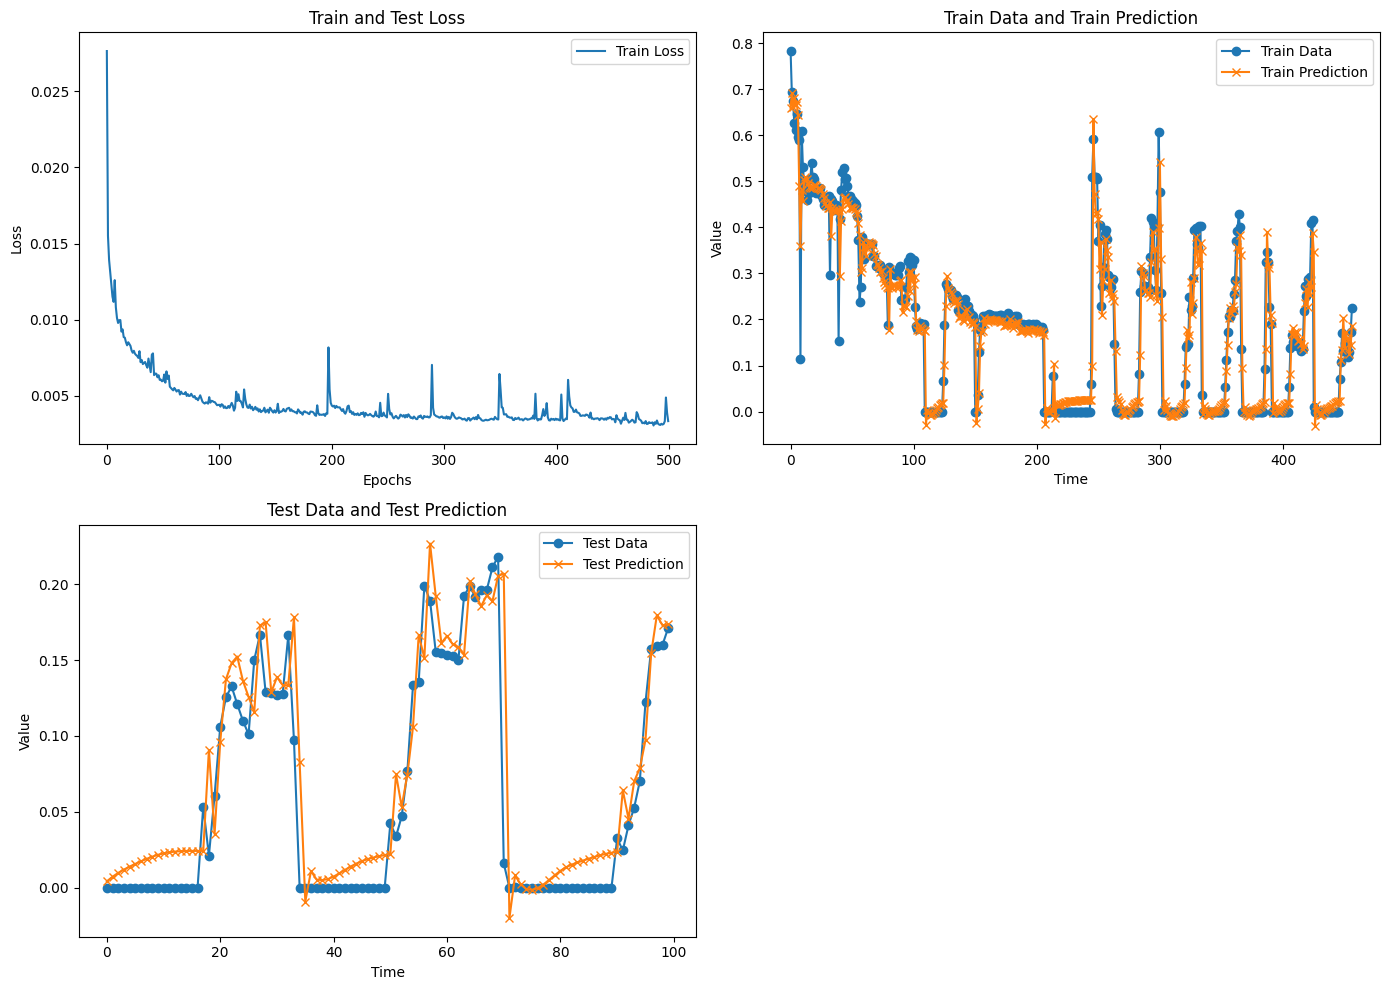

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

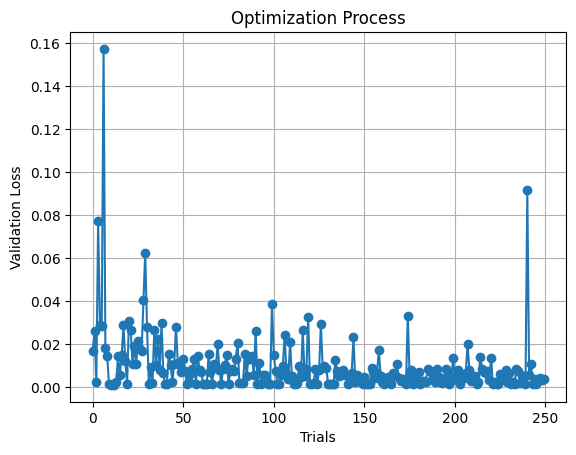

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

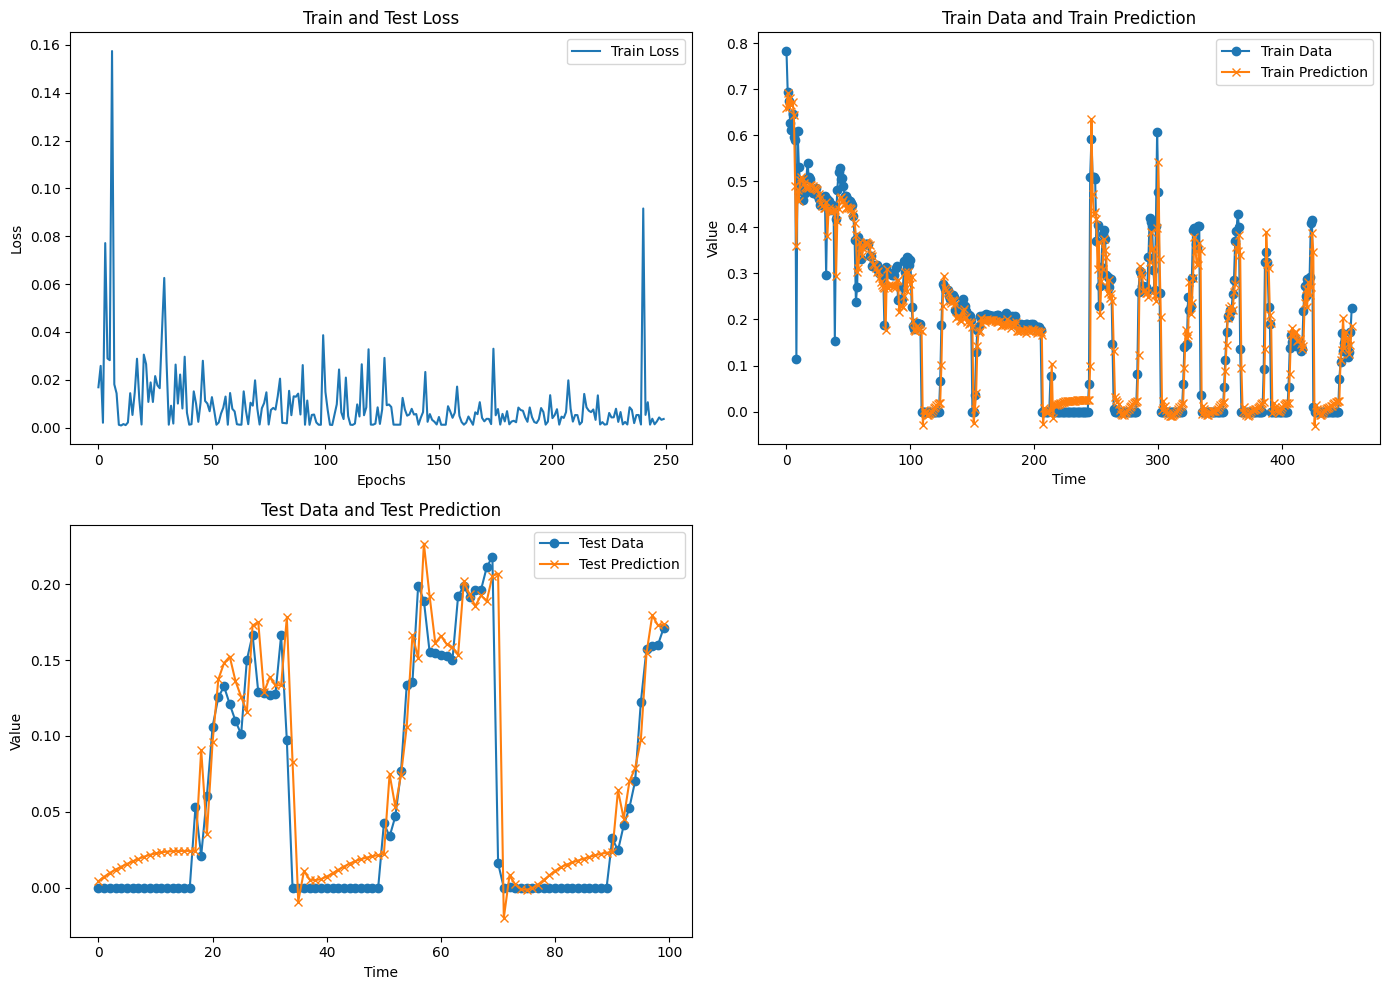

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.006081160307610209
Test MSE: 0.0008886204596759835


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.003128  0.000915
1  Baseline   0.006081  0.000889


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 34, 'n_lstm_layers': 12, 'lstm_units': 146, 'learning_rate': 0.004393180926354533, 'Dropout_rate': 0.18793444307393223}
Trial 2: {'window_size': 13, 'n_lstm_layers': 14, 'lstm_units': 57, 'learning_rate': 0.008152054036511319, 'Dropout_rate': 0.3569955676903557}
Trial 3: {'window_size': 10, 'n_lstm_layers': 8, 'lstm_units': 65, 'learning_rate': 0.0007733715870985217, 'Dropout_rate': 0.3187377971381219}
Trial 4: {'window_size': 45, 'n_lstm_layers': 6, 'lstm_units': 158, 'learning_rate': 0.002524072258948971, 'Dropout_rate': 0.43857815030847913}
Trial 5: {'window_size': 6, 'n_lstm_layers': 8, 'lstm_units': 149, 'learning_rate': 0.008362037957306664, 'Dropout_rate': 0.3766020565232121}
Trial 6: {'window_size': 53, 'n_lstm_layers': 6, 'lstm_units': 68, 'learning_rate': 0.007892094038297551, 'Dropout_rate': 0.40420152581857194}
Trial 7: {'window_size': 57, 'n_lstm_layers': 18, 'lstm_units': 230, 'learning_rate': 0.0076036008